In [3]:
import numpy as np
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt
plt.style.use(astropy_mpl_style)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from photutils.segmentation import make_source_mask

In [4]:
def calibrate(img, bias, dark, flat):
    """ Image (img) calibration using a bias frame, a dark frame and a flat frame
    : img: raw image of interest
      bias: bias image (shortest exposure of nothing) --> readout noise
      dark: dark image (same exposure time as img, but of nothing) --> thermal noise
      flat: flat image (image to correct for vignetting)
      
      return: matrix of image
    """
    #clean_image = (img - dark) * np.mean(flat - dark) / (flat - dark) # source: https://en.wikipedia.org/wiki/Flat-field_correction
    #clean_image = (img - flat - bias) / np.mean(dark)
    flat = flat - bias
    flat = flat + (np.abs(np.min(flat))+1) * np.ones(shape=np.shape(flat)) # to avoid a zero, no difference in final result
    flat = flat / np.mean(flat)
    clean_image = (img - bias) / flat # source: http://spiff.rit.edu/classes/phys445/lectures/darkflat/darkflat.html
    #clean_image = img/flat * np.mean(flat)
    return clean_image
  

def averageImages(path_to_images):
    """ Average the images
    : path_to_images: list of strings indicating the paths to .fit images

    return: matrix of image
    """
    N = len(path_to_images)
    with fits.open(path_to_images[0]) as file:
        final_img = np.ndarray(shape=np.shape(file[0].data))
    for path in path_to_images:
        with fits.open(path) as file:
            final_img += file[0].data/N
    return final_img


def averageFolder(path_to_folder):
    """ Average image of all the .fit images in folder
    : path_to_folder: string of path to folder

    return: matrix of image
    """
    path_to_images = []
    for file in os.listdir(path_to_folder):
        if file.endswith(".fit"):
            path_to_images.append(os.path.join(path_to_folder, file))
    return averageImages(path_to_images)


In [5]:
# Opening the images
from PIL import Image

img = fits.getdata('image2.fit')
bias = fits.getdata('bias.fit')
dark = fits.getdata('dark.fit')
flat = fits.getdata('flat.fit')

# saving the images
tmp = img/np.mean(img) * 128
im = Image.fromarray(tmp)
print(np.mean(tmp))
if im.mode != 'RGB':
    im = im.convert('RGB')
im.save("raw.png")

# Averaging the calibration frames
bias = averageFolder('bias')
dark = averageFolder('dark')
flat = averageFolder('flat')

127.99999999999974


/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_5423/3715594607.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


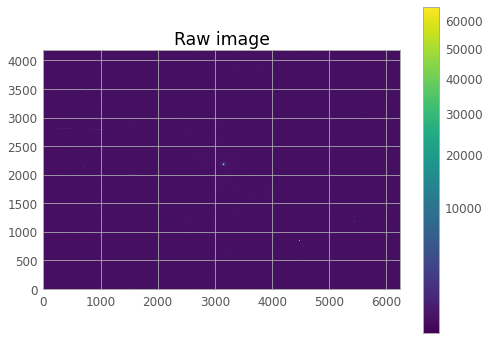

In [6]:
plt.figure()
plt.title('Raw image')
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(img, norm=norm, interpolation='none', origin='lower', cmap='viridis')
plt.colorbar()
plt.show()

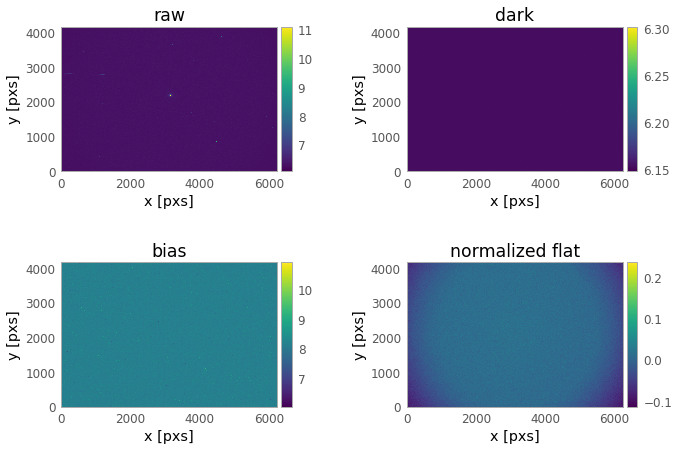

In [7]:
# Plotting all images
fig, axs = plt.subplots(2, 2)
axs[0,0].grid(False)
axs[0, 1].grid(False)
axs[1, 0].grid(False)
axs[1, 1].grid(False)


im = axs[0,0].imshow(np.log(img), interpolation='none', origin='lower', cmap='viridis')
axs[0,0].set_title('raw')
axs[0,0].set_xlabel('x [pxs]')
axs[0,0].set_ylabel('y [pxs]')
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
cax.grid(False)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[0,1].imshow(np.log(dark), interpolation='none', origin='lower', cmap='viridis')
axs[0,1].set_title('dark')
axs[0,1].set_xlabel('x [pxs]')
axs[0,1].set_ylabel('y [pxs]')
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
cax.grid(False)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1,0].imshow(np.log(bias), interpolation='none', origin='lower', cmap='viridis')
axs[1,0].set_title('bias')
axs[1,0].set_xlabel('x [pxs]')
axs[1,0].set_ylabel('y [pxs]')
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cax.grid(False)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1,1].imshow(np.log(flat/np.mean(flat)), interpolation='none', origin='lower', cmap='viridis')
axs[1,1].set_title('normalized flat')
axs[1,1].set_xlabel('x [pxs]')
axs[1,1].set_ylabel('y [pxs]')
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cax.grid(False)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.subplots_adjust(left=0.,
                    bottom=0., 
                    right=1, 
                    top=1, 
                    wspace=0.5, 
                    hspace=0.2)
plt.show()

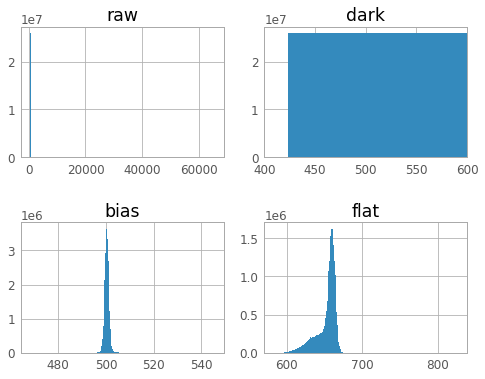

In [8]:
# Histogramm of all images
fig, axs = plt.subplots(2,2)
axs[0,0].set_title('raw')
axs[0,0].hist(img.flatten(), bins=256)
#darks = [d for d in dark.flatten() if d < 1000]
axs[0,1].set_title('dark')
axs[0,1].hist(dark.flatten(), bins=256)
axs[0,1].set_xlim(400, 600)
axs[1,0].set_title('bias')
axs[1,0].hist(bias.flatten(), bins=256)
axs[1,1].set_title('flat')
axs[1,1].hist(flat.flatten(), bins=256)
plt.show()

/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_5423/301236486.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ca = plt.colorbar()


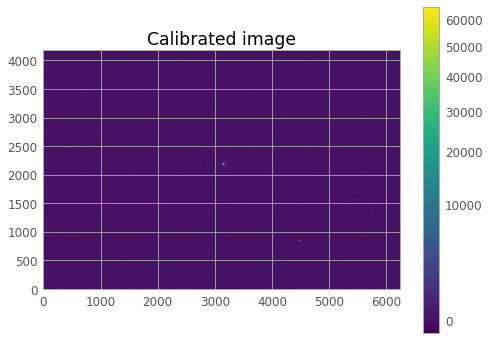

In [9]:
# Image calibrated using the different calibration frames
#from fonctions import *
image_clean = calibrate(img, bias, dark, flat)
#image_clean = image_clean - np.min(image_clean)
#image_clean = image_clean / np.max(image_clean) * (2**16-1)
plt.figure()
plt.title('Calibrated image')
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(image_clean, norm=norm, origin='lower', cmap='viridis', interpolation='none')
ca = plt.colorbar()
plt.show()
tmp = image_clean/np.mean(image_clean) * 128
im = Image.fromarray(tmp)
if im.mode != 'RGB':
    im = im.convert('RGB')
im.save("calibrated.png")

/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_5423/2921287680.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


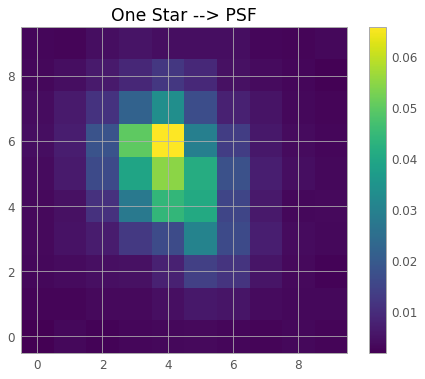

In [10]:
# PSF of one star
#PSF = image_clean[2926-10:2926+10, 2029-10:2029+10]
PSF = image_clean[2628:2638, 822:832]
PSF = PSF / np.sum(PSF) #normalized as a distribution to 1
plt.figure()
plt.title('One Star --> PSF')
plt.imshow(PSF, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()


/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_5423/2901152817.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


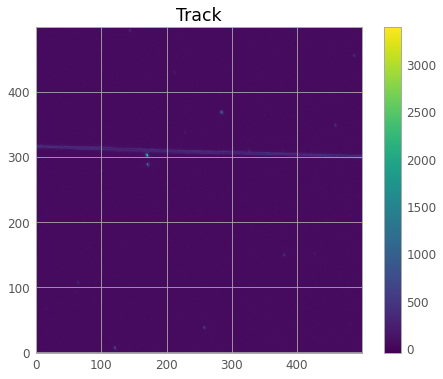

/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_5423/2901152817.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


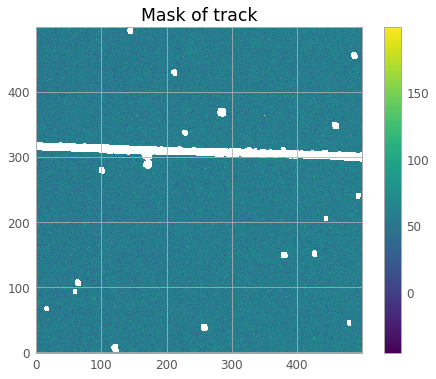

/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_5423/2901152817.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


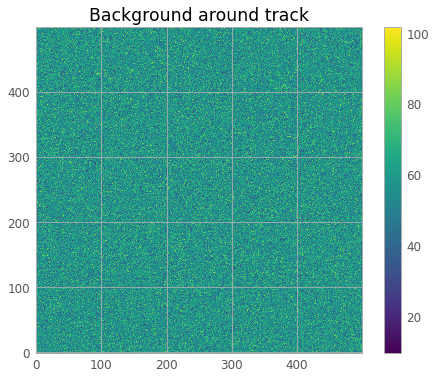

In [11]:
# small outcut of a track
track_data = image_clean[2500:3000,0:500]
avg = np.mean(track_data)
mask = make_source_mask(track_data, nsigma=4, npixels=5, dilate_size=5)
mean, median, std = sigma_clipped_stats(track_data, sigma=4.0, mask=mask)
random_background = np.random.normal(mean, std, np.shape(track_data))
mask = make_source_mask(track_data, nsigma=4, npixels=5, dilate_size=5)
masked_image = np.ma.masked_where(mask, track_data)

plt.figure()
plt.title('Track')
plt.imshow(track_data, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

plt.figure()

plt.title('Mask of track')
plt.imshow(masked_image, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background around track')
plt.imshow(random_background, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_5423/2784962600.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


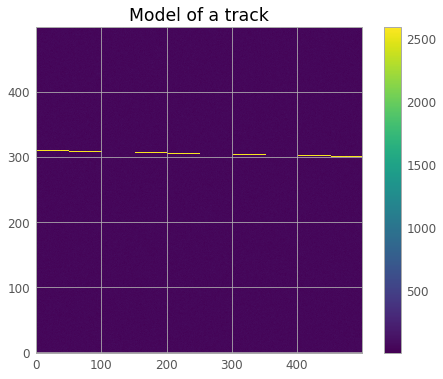

In [12]:
# Basic model of a track
#track_model = avg * np.ones((100, 100))
track_model = random_background
#for i in range(55,100):
 #   track_model[2*(i-55), i] = 85000
for i in range(500):
    track_model[int(310-10/500 * i), i] += 2500
    
plt.figure()
plt.title('Model of a track')
plt.imshow(track_model, interpolation='none', origin='lower', cmap='viridis')
plt.colorbar()
plt.show()

/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_5423/1429265752.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


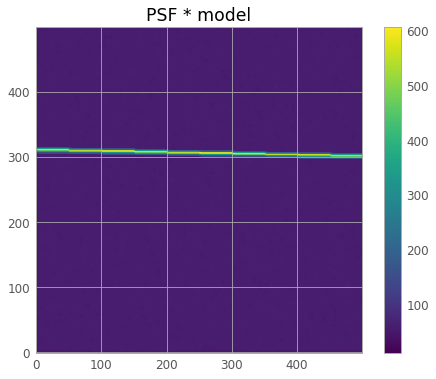

In [13]:
# Convolution of model and PSF to get what we would measure
from scipy.signal import convolve2d
convolved_track = convolve2d(track_model, PSF, 'same')
plt.figure()
plt.title('PSF * model')
plt.imshow(convolved_track, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()